In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

ModuleNotFoundError: No module named 'numpy'

In [5]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()



,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [6]:
data = data.astype(dict(series=str))

In [7]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)



In [8]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5462)

In [9]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:  75%|███████▌  | 75/100 [00:25<00:08,  2.98it/s]
LR finder stopped early after 75 steps due to diverging loss.
Learning rate set to 0.022387211385683406
Restoring states from the checkpoint path at c:\Users\Florian\SynologyDrive\TUB\7_Codes\BMS_SOC\.lr_find_4f37c00b-141a-46f1-b4aa-b452820605b1.ckpt
Restored all states from the checkpoint at c:\Users\Florian\SynologyDrive\TUB\7_Codes\BMS_SOC\.lr_find_4f37c00b-141a-46f1-b4aa-b452820605b1.ckpt


suggested learning rate: 0.022387211385683406


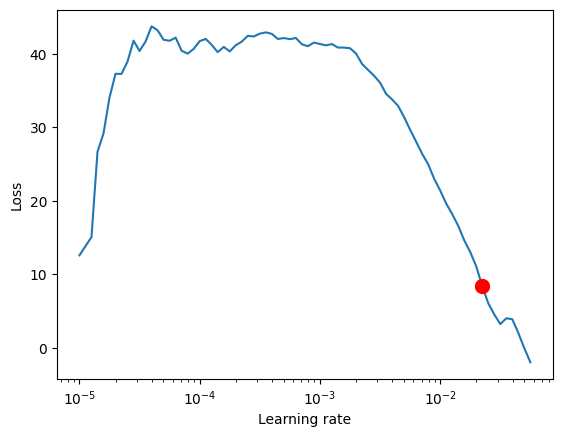

In [10]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [11]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 2.1 K 
3 | rnn                    | LSTM                               | 13.9 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s, v_num=28, train_loss_step=-67.5, val_loss=-67.0, train_loss_epoch=-125.]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s, v_num=28, train_loss_step=-67.5, val_loss=-67.0, train_loss_epoch=-125.]


In [12]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)



In [13]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3442)

In [14]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


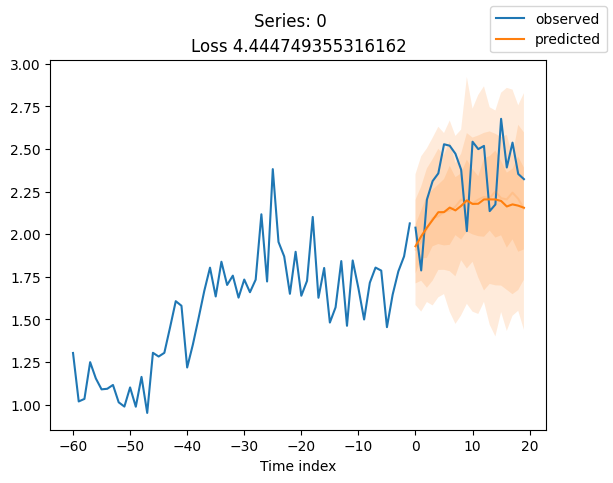

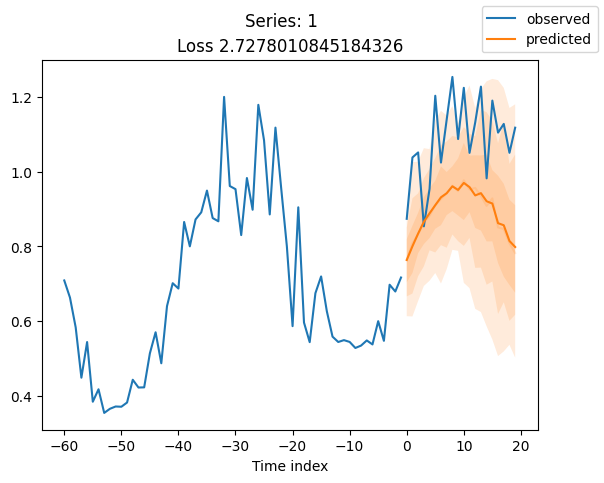

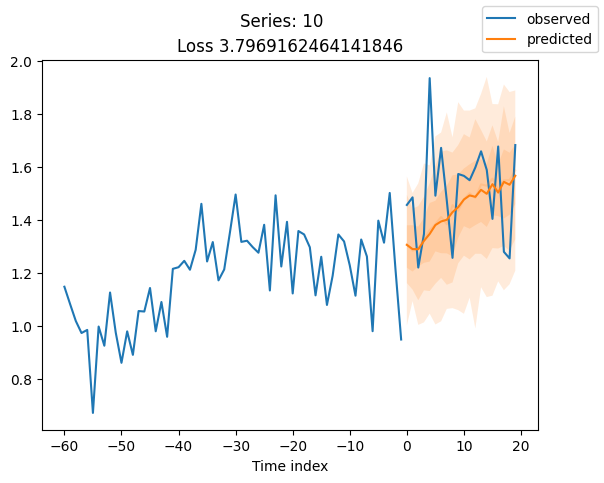

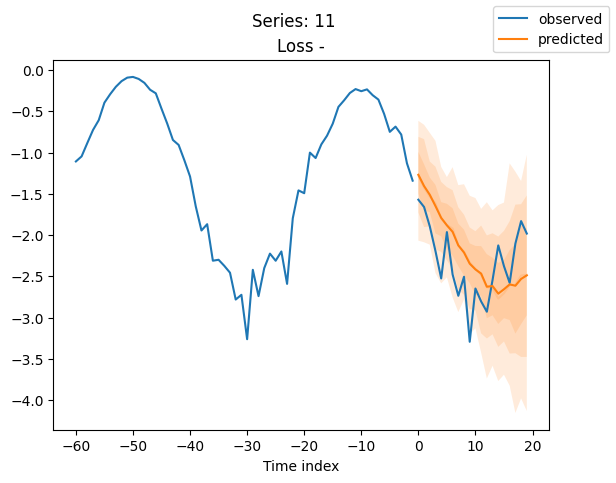

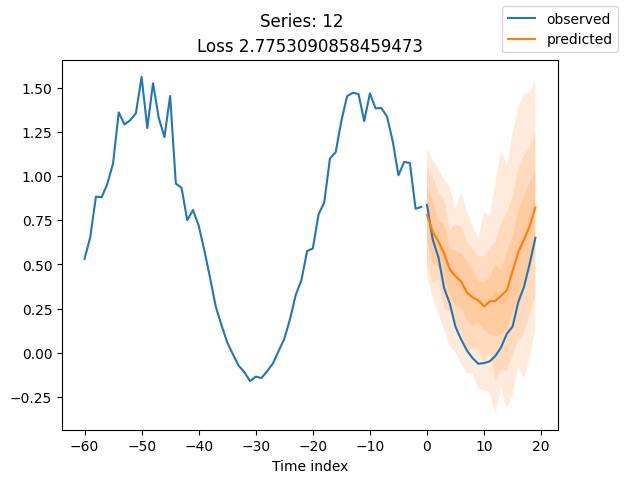

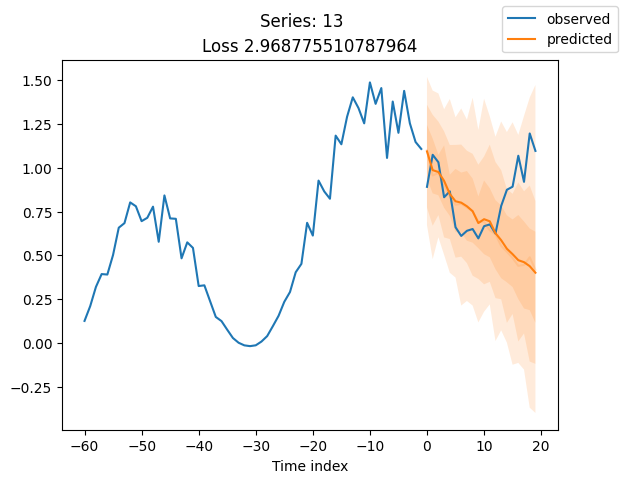

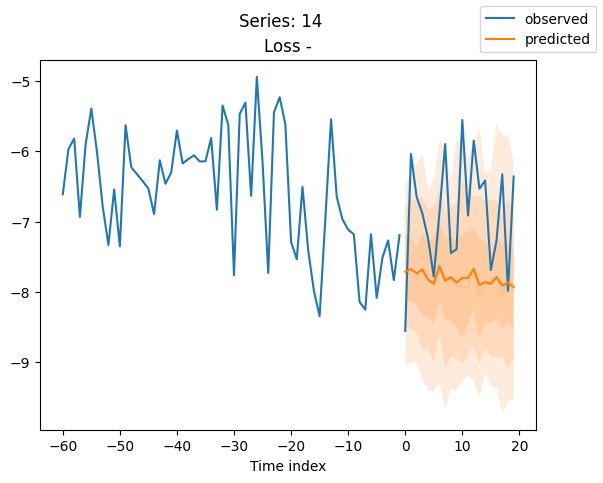

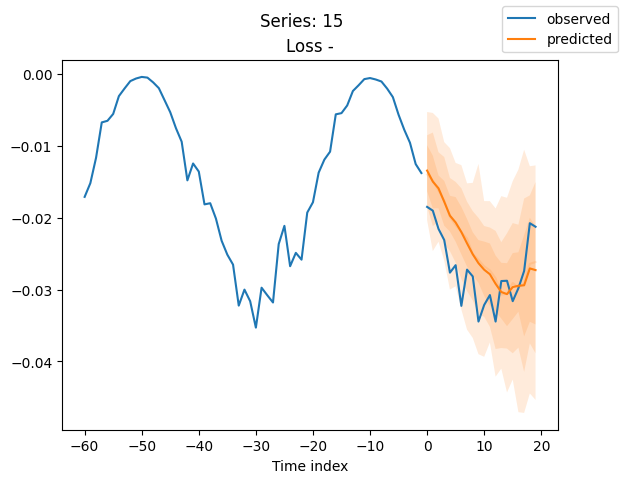

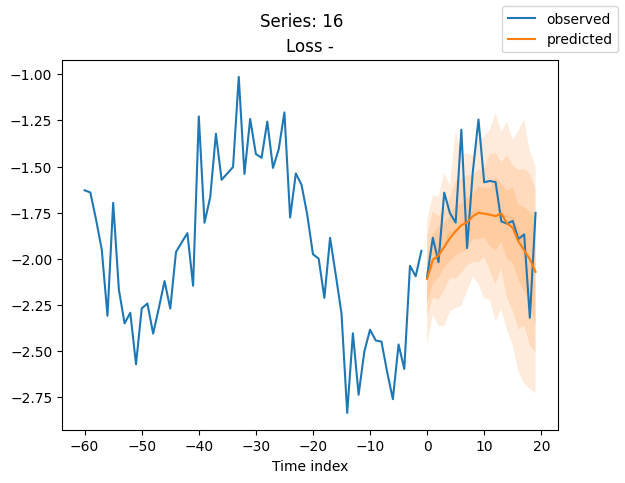

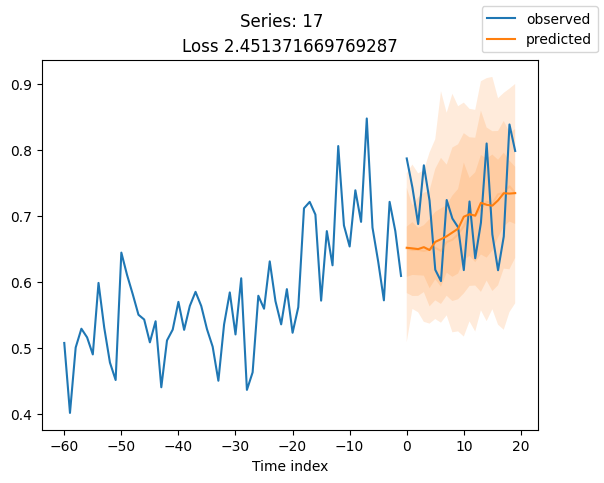

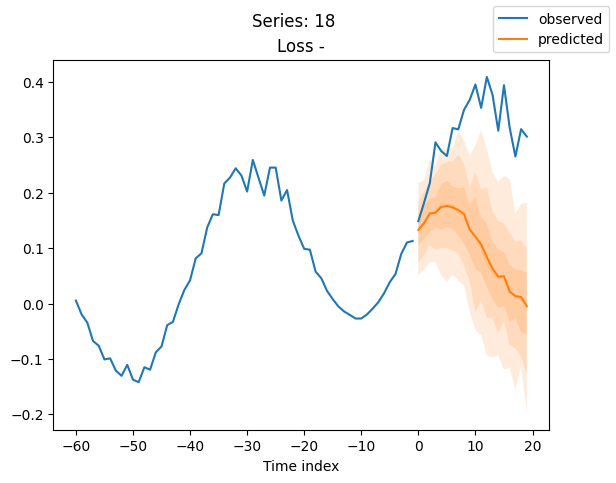

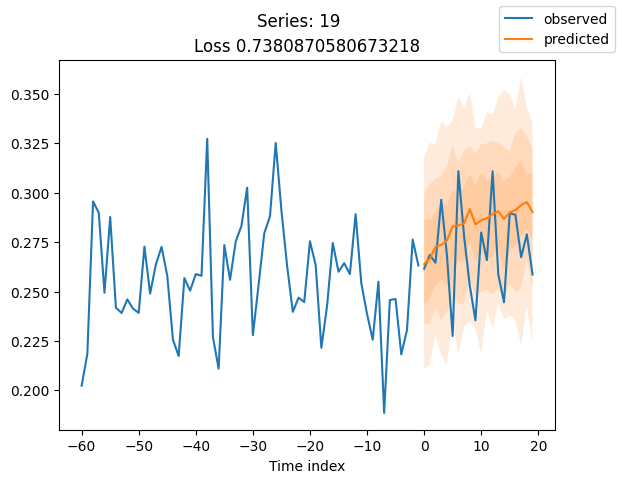

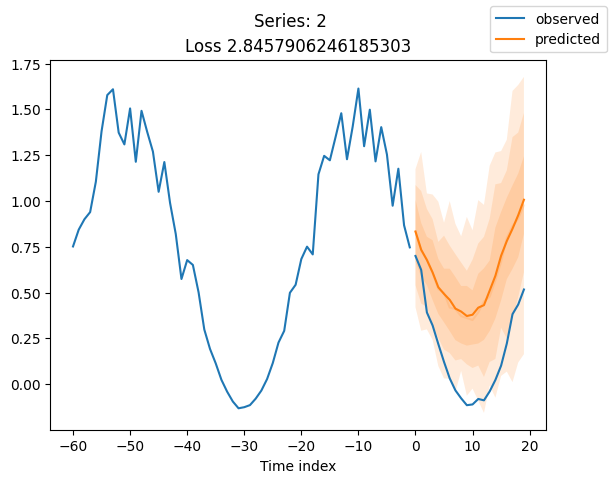

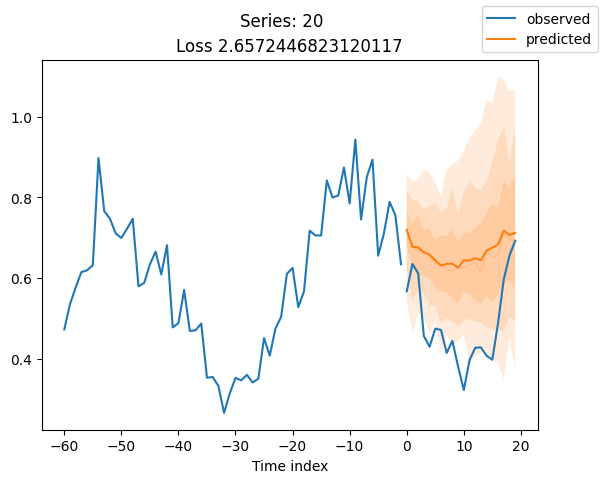

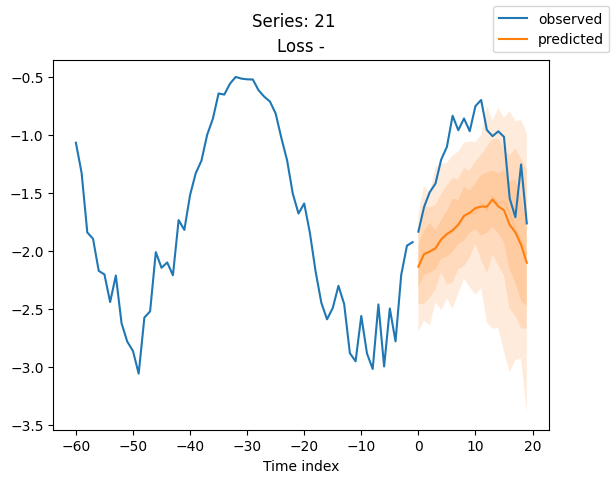

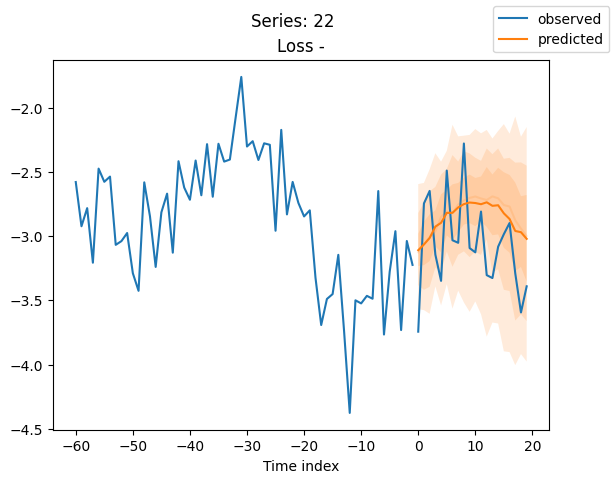

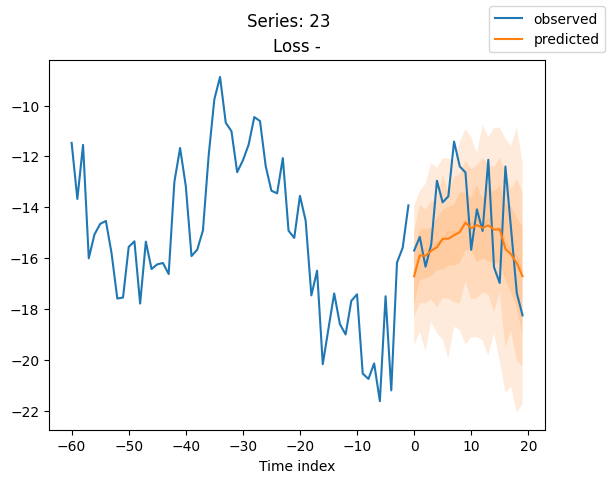

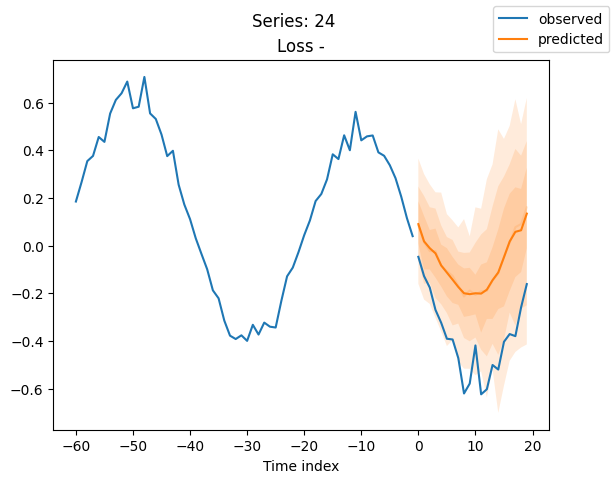

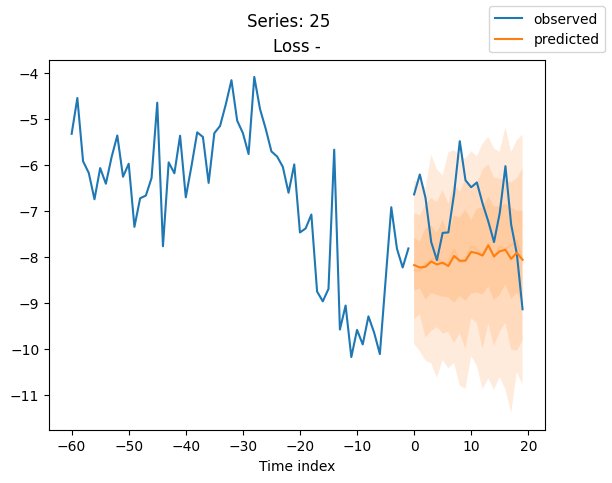

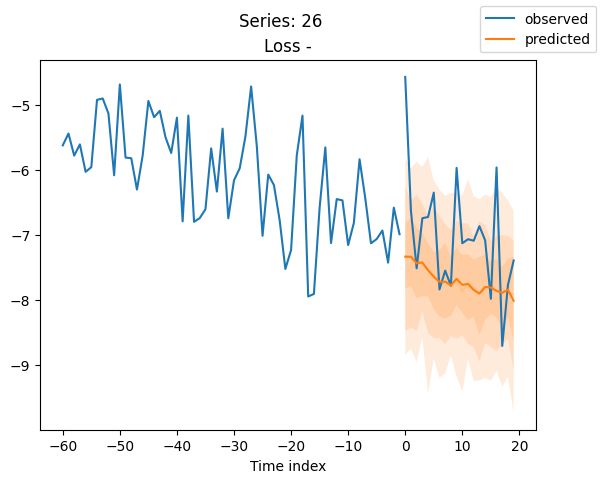

In [15]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

